In [1]:
import math

import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import torch
from tqdm import tqdm

In [4]:
class KuramotoCPG(nn.Module):
    def __init__(
        self,
        n_cpgs,
        dt=0.004,
        alpha_w=600,
        alpha_psi=math.pi,
        alpha_omega=20,
        alpha_A=0.8,
        alpha_B=0.2,
        alpha_a=1,
        beta_a=1,
        alpha_b=1,
        beta_b=1,
    ):
        super().__init__()
        self.dt = dt
        self.n_cpgs = n_cpgs

        # Co-effs
        self.c_w = alpha_w
        self.c_psi = alpha_psi
        self.c_omega = alpha_omega
        self.c_A = alpha_A
        self.c_B = alpha_B
        self.c_a = alpha_a
        self.beta_a = beta_a
        self.c_b = alpha_b
        self.beta_b = beta_b

    def forward(self, w, psi, omega, A, B, phi, phi_d, a, a_d, a_dd, b, b_d, b_dd):
        """
        w: (b, n, n)  Symmetric
        psi: (b, n, n)  Skew Symmetric
        omega: (b, n)
        A: (b, n)
        B: (b, n)
        
        phi: (b, n)
        phi_d: (b, n)
        a: (b, n)
        a_d: (b, n)
        a_dd: (b, n)
        b: (b, n)
        b_d: (b, n)
        b_dd: (b, n)
        
        return y: (b, n)
        """

        batch_size, n, n = w.shape

        w = self.to_symmetric(w)  # (b, n, n)
        psi = self.to_symmetric(psi, skew=True)  # (b, n, n)

        a_j = a.unsqueeze(1).expand(batch_size, n, n)  # (b, n, n)
        phi_i = phi.unsqueeze(2).expand(batch_size, n, n)  # (b, n, n)
        phi_j = phi.unsqueeze(1).expand(batch_size, n, n)  # (b, n, n)
        c1, c2, c3 = self.c_omega, self.c_w, self.c_psi
    
        phi_d_new = c1 * omega + (a_j * c2 * w * torch.sin(phi_j - phi_i - c3 * psi)).sum(axis=-1)
        phi_new = phi + phi_d * self.dt

        a_dd_new = self.c_a * (self.beta_a * (self.c_A * A - a) - a_d)
        a_d_new = a_d + a_dd * self.dt
        a_new = a + a_d * self.dt

        b_dd_new = self.c_b * (self.c_b * (self.c_B * B - b) - b_d)
        b_d_new = b_d + b_dd * self.dt
        b_new = b + b_d * self.dt

        y = b_new + a_new * torch.sin(phi_new)

        return y, (phi_new, phi_d_new, a_new, a_d_new, a_dd_new, b_new, b_d_new, b_dd_new)
    
    @staticmethod
    def to_symmetric(x, skew=False):
        b, n, m = x.shape
        assert n == m
        i, j = torch.triu_indices(n, n, offset=1)  # Get indices of upper triangle
        skew = -1 if skew else 1
        x.transpose(1, 2)[:, i, j] = x[:, i, j] * skew  # Update the lower triangle with upper values.
        x[:] = x * (1 - torch.eye(n).expand(b, n, n))  # Set diagonal to 0
        return x

100%|██████████| 5000/5000 [00:00<00:00, 9712.77it/s]


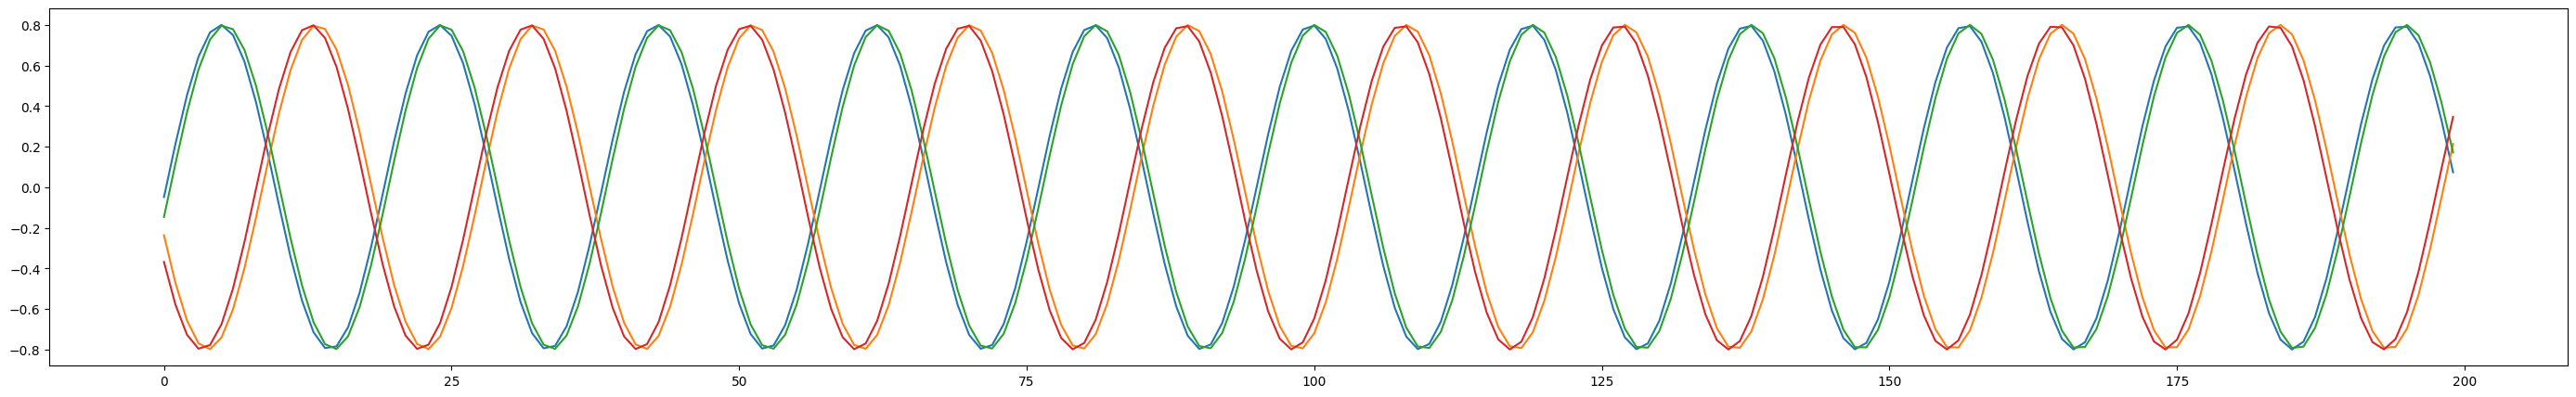

In [18]:
b = 2
n = 4
cpg_layer = KuramotoCPG(n_cpgs=n, dt=0.005)

ys = []
h = (
    # phi
    torch.tensor([(30 * i) % 360 * math.pi / 180 for i in range(n)] * b).view(b, n),
    torch.zeros(b, n),  # phi_d
    
    torch.ones(b, n),  # a
    torch.zeros(b, n),  # a_d
    torch.zeros(b, n),  # a_dd
    
    torch.zeros(b, n),  # b
    torch.zeros(b, n),  # b_d
    torch.zeros(b, n),  # b_dd
)
# psi = np.random.rand(b, n, n) * 2 * math.pi  # [0-pi]
# psi = np.zeros((b, n, n)) * math.pi  # [0-pi]
psi = np.zeros((b, n, n)) * math.pi  # [0-pi]



w = np.random.rand(b, n, n) * 0.1  # [0-1]
omega = np.random.rand(b, n) * 5
A = np.ones((b, n))
B = np.zeros((b, n)) * 0
for iteration in tqdm(range(5000)):

    y, h = cpg_layer(
        w=torch.tensor(w),
        psi=torch.tensor(psi),
        omega=torch.tensor(omega),
        A=torch.tensor(A),
        B=torch.tensor(B),

        phi=h[0],
        phi_d=h[1],

        a=h[2],
        a_d=h[3],
        a_dd=h[4],

        b=h[5],
        b_d=h[6],
        b_dd=h[7],
    )
    ys.append(y[0].tolist())
ys = np.array(ys).T
plt.figure(figsize=(35, 5))
for y in ys:
    plt.plot(y[-200:])

In [50]:
[h_[0] for h_ in h]

[tensor([4985.5795, 7232.7552, 4985.7069, 4381.9651], dtype=torch.float64),
 tensor([64.5858, 99.1055, 65.7125, 58.3869], dtype=torch.float64),
 tensor([0.8000, 0.8000, 0.8000, 0.8000], dtype=torch.float64),
 tensor([8.6597e-15, 8.6597e-15, 8.6597e-15, 8.6597e-15], dtype=torch.float64),
 tensor([9.3050e-21, 9.3050e-21, 9.3050e-21, 9.3050e-21], dtype=torch.float64),
 tensor([0., 0., 0., 0.], dtype=torch.float64),
 tensor([0., 0., 0., 0.], dtype=torch.float64),
 tensor([0., 0., 0., 0.], dtype=torch.float64)]

(2, 4, 4)